## Imports and settings

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
import pprint

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
import pprint

detector_path = '..'
results_path = os.path.join(detector_path, 'results')
sys.path.append(detector_path)

from utils import constants
from utils import errors
from sleep.mass import MASS
from sleep.inta import INTA
from sleep import postprocessing
from sleep import data_ops
from evaluation import metrics
from evaluation import data_manipulation

DPI = 200

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load database and predicted probabilities

In [2]:
# TODO: evaluar la curva para cada semilla en VAL,
# mostrar todas las curvas superpuestas y ademas el promedio, y mostrar el PR de cada semilla.

n_seeds = 4

# Select database
dataset_name = constants.MASS_NAME
# Select predictions ckpt folder
ckpt_folder = '20190401_type_bn'
grid_folder_list = ['bn', 'bn_renorm']
verbose = False

# Load data

# Marks are binary sequences for each page, 200 fs resolution
errors.check_valid_value(
    dataset_name, 'dataset_name',
    [constants.MASS_NAME, constants.INTA_NAME])
if dataset_name == constants.MASS_NAME:
    dataset = MASS(load_checkpoint=True)
else:
    dataset = INTA(load_checkpoint=True)

# Get training set ids
print('Loading train set... ', end='', flush=True)
all_train_ids = dataset.train_ids
# Get subjects data, with the expert used for training
all_x, all_y = dataset.get_subset_data(all_train_ids, which_expert=1, verbose=verbose)
print('Signals and marks loaded... ', end='', flush=True)
all_pages = dataset.get_subset_pages(all_train_ids, verbose=verbose)
print('Pages loaded.', flush=True)

# Load predictions (probability vectors for each page), 200/factor resolution (default factor 8)
set_list = ['train', 'val']
y_pred = {}
seed_list = []
for j, folder_name in enumerate(grid_folder_list):
    print('\nGrid setting: %s' % folder_name)
    y_pred[folder_name] = []
    for k in range(n_seeds):
        print('\n%d / %d' % (k+1, n_seeds))
        ckpt_path = os.path.abspath(os.path.join(
            results_path,
            '%s_train_%s' % (ckpt_folder, dataset_name),
            folder_name,
            'seed%d' % k
        ))
        if j==0:
        # Restore seed
            filename = os.path.join(ckpt_path, 'metric.json')
            print('Loading seed from %s' % filename)
            with open(filename, 'r') as infile:
                metric_dict = json.load(infile)
                this_seed = metric_dict['val_seed']
                seed_list.append(this_seed)
                print('Validation split seed: %d' % this_seed)
        # Restore predictions
        ckpt_path = os.path.abspath(os.path.join(
            results_path,
            'predictions_%s' % dataset_name,
            '%s_train_%s' % (ckpt_folder, dataset_name),
            folder_name,
            'seed%d' % k
        ))
        print('Loading predictions from %s' % ckpt_path)
        this_dict = {}
        for set_name in set_list:
            this_dict[set_name] = np.load(os.path.join(ckpt_path, 'y_pred_%s.npy' % set_name), allow_pickle=True)
            # Keep only class 1 probability
            this_dict[set_name] = [this_y_pred[..., 1] for this_y_pred in this_dict[set_name]]
        y_pred[folder_name].append(this_dict)

Dataset mass with 15 patients.
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Loading from checkpoint... Loaded
Loading train set... Signals and marks loaded... Pages loaded.

Grid setting: bn

1 / 4
Loading seed from /home/ntapia/Projects/GitNico/ssdetection-rnn/detector/results/20190401_type_bn_train_mass/bn/seed0/metric.json
Validation split seed: 123
Loading predictions from /home/ntapia/Projects/GitNico/ssdetection-rnn/detector/results/predictions_mass/20190401_type_bn_train_mass/bn/seed0

2 / 4
Loading seed from /home/ntapia/Projects/GitNico/ssdetection-rnn/detector/results/20190401_type_bn_train_mass/bn/seed1/metric.json
Validation split seed: 234
Loading predictions from /home/ntapia/Projects/GitNico/ssdetection-rnn/detector/results/predictions_mass/20190401_type_bn_train_mass/bn/seed1

3 / 4
Loading seed from /home/ntapia/Projects/GitNico/ssdetection-rnn/detector/results/20190401_type_bn_train_mass/bn/seed

In [3]:
# Prepare expert labels into marks
print('Preparing labels... ', end='', flush=True)
all_y_stamps = postprocessing.generate_mark_intervals_with_list(
        all_y, all_pages, 200, 200, thr=None, postprocess=False)
print('Done')

Preparing labels... Done


## Validation performance: F1 vs IoU

In [6]:
# Performance settings
thr = 0.5

# ---------------- Compute performance
print('Using thr %1.4f' % thr)

val_f1 = {}
iou_list = np.arange(1, 10) * 0.1
for folder_name in grid_folder_list:
    print('\nGrid setting: %s' % folder_name)
    val_f1[folder_name] = []
    for k, seed in enumerate(seed_list):
        # Prepare expert labels
        _, val_ids = data_manipulation.split_ids_list(
            all_train_ids, seed=seed)
        print(val_ids)
        val_idx = [all_train_ids.index(this_id) for this_id in val_ids]
        y_thr = [all_y_stamps[i] for i in val_idx]
        pages = [all_pages[i] for i in val_idx]
        # Prepare model predictions
        print('Preparing predictions', flush=True)
        y_pred_thr = postprocessing.generate_mark_intervals_with_list(
            y_pred[folder_name][k]['val'], pages, 200//8, 200, thr=thr)
        # Go through several IoU values
        print('Computing F1 Curve', flush=True)
        all_f1_list = [metrics.f1_vs_iou(this_y, this_y_pred, iou_list) 
                       for (this_y, this_y_pred) 
                       in zip(y_thr, y_pred_thr)]
        all_f1_list = np.stack(all_f1_list, axis=1)
        mean_f1 = np.mean(all_f1_list, axis=1)
        val_f1[folder_name].append(mean_f1)
print('Done')

Using thr 0.5000

Grid setting: bn
Split IDs: Total 11 -- Training 8
[11, 19, 5]
Preparing predictions
Computing F1 Curve
Split IDs: Total 11 -- Training 8
[3, 9, 17]
Preparing predictions
Computing F1 Curve
Split IDs: Total 11 -- Training 8
[7, 1, 17]
Preparing predictions
Computing F1 Curve
Split IDs: Total 11 -- Training 8
[9, 18, 10]
Preparing predictions
Computing F1 Curve

Grid setting: bn_renorm
Split IDs: Total 11 -- Training 8
[11, 19, 5]
Preparing predictions
Computing F1 Curve
Split IDs: Total 11 -- Training 8
[3, 9, 17]
Preparing predictions
Computing F1 Curve
Split IDs: Total 11 -- Training 8
[7, 1, 17]
Preparing predictions
Computing F1 Curve
Split IDs: Total 11 -- Training 8
[9, 18, 10]
Preparing predictions
Computing F1 Curve
Done



Grid setting: bn
[0.7849895397187165,
 0.7845916368738648,
 0.7825144527128749,
 0.7748970578351994,
 0.7636347122508148,
 0.7399463862656341,
 0.6794697190188764,
 0.5207170805556479,
 0.20375103875619818]
IoU list for AF1: [0.3 0.4 0.5 0.6 0.7 0.8]
Val AF1: 0.7102 +- 0.0913

Grid setting: bn_renorm
[0.7778380571894378,
 0.7773953671366854,
 0.775192328850006,
 0.7693274867042268,
 0.7587279821754075,
 0.7389953396845034,
 0.6792633624043262,
 0.5260729530418454,
 0.21961873328890458]
IoU list for AF1: [0.3 0.4 0.5 0.6 0.7 0.8]
Val AF1: 0.7079 +- 0.0873


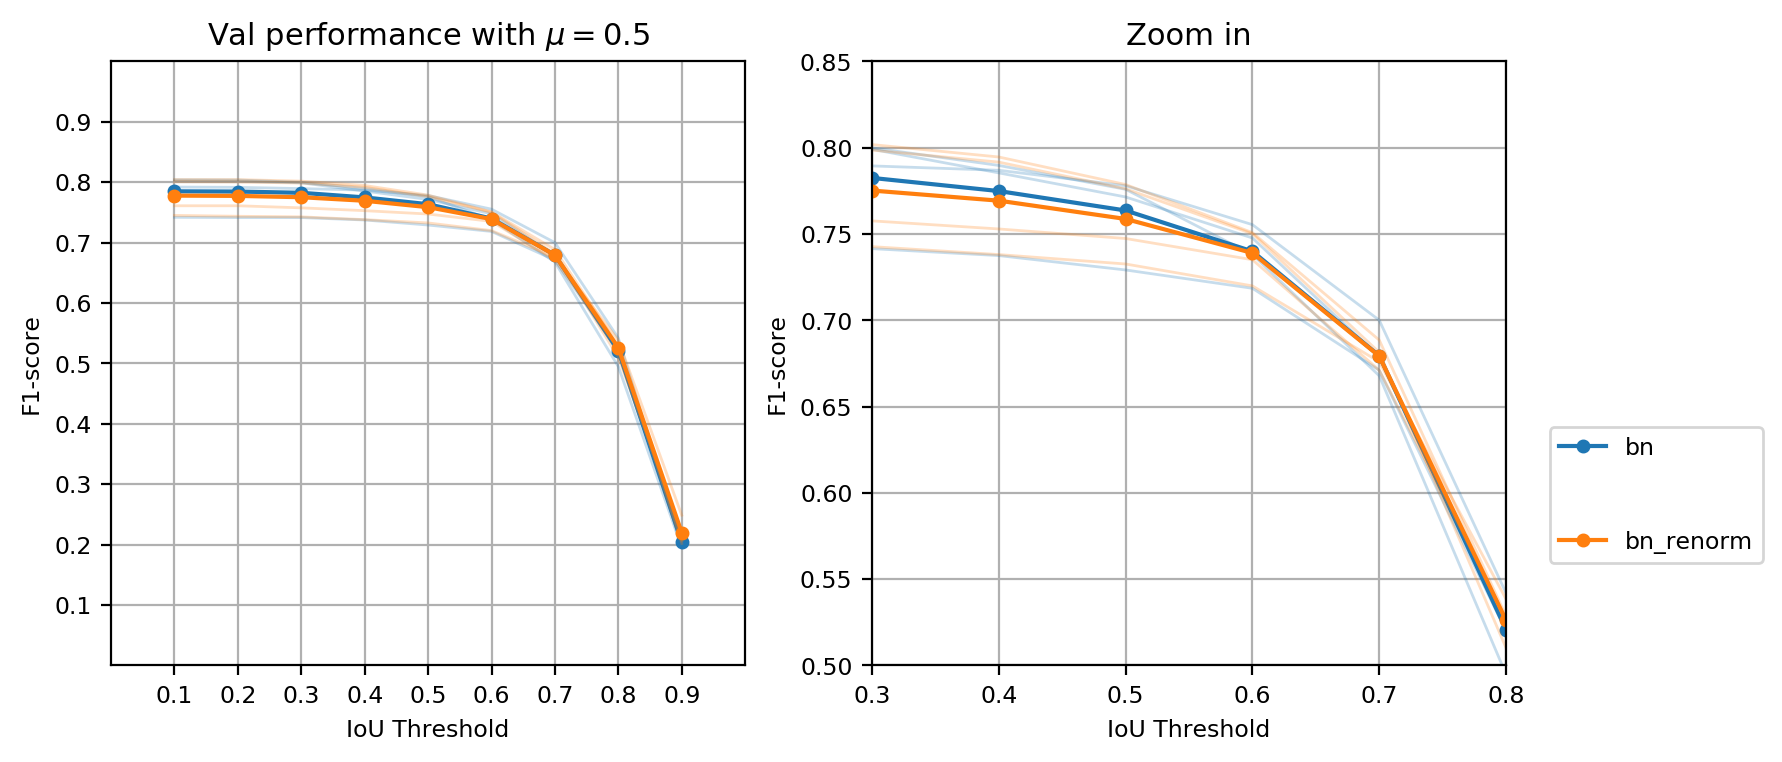

In [54]:
# Comparison settings
alpha = 0.2
color_list = {}
for k, folder_name in enumerate(grid_folder_list):
    color_list[folder_name] = 'C%d' % k
zoom_xlim = [0.3, 0.8]
zoom_ylim = [0.5, 0.85]
linewidth_mean = 1.5
markersize_mean = 8
linewidth_single = 1
markersize_single = 8

# -------------------- P L O T ----------------------    
fig, ax = plt.subplots(1, 2, figsize=(9, 4), dpi=DPI)

# Complete plot
for folder_name in grid_folder_list:
    for k in range(n_seeds):
        ax[0].plot(iou_list, val_f1[folder_name][k], 
                   linewidth=linewidth_single, markersize=markersize_single, 
                   color=color_list[folder_name], alpha=0.25)
    mean_val_f1 = np.stack(val_f1[folder_name], axis=1).mean(axis=1)
    print('\nGrid setting: %s' % folder_name)
    pprint.pprint(mean_val_f1.tolist())
    print('IoU list for AF1:', iou_list[2:-1])
    print('Val AF1: %1.4f +- %1.4f' % (mean_val_f1[2:-1].mean(), mean_val_f1[2:-1].std()))
    ax[0].plot(iou_list, mean_val_f1, 
           linewidth=linewidth_mean, markersize=markersize_mean, marker='.',
           color=color_list[folder_name])
ax[0].set_title('Val performance with $\mu=%1.1f$' % (thr), fontsize=11)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0.1*i for i in range(1, 10)])
ax[0].set_xticks([0.1*i for i in range(1, 10)])
ax[0].tick_params(labelsize=8.5)
ax[0].set_xlabel('IoU Threshold', fontsize=8.5)
ax[0].set_ylabel('F1-score', fontsize=8.5)
ax[0].grid()

# Zoom plot
for folder_name in grid_folder_list:
    for k in range(n_seeds):
        ax[1].plot(iou_list, val_f1[folder_name][k], 
                   linewidth=linewidth_single, markersize=markersize_single, 
                   color=color_list[folder_name], alpha=0.25)
    mean_val_f1 = np.stack(val_f1[folder_name], axis=1).mean(axis=1)
    ax[1].plot(iou_list, mean_val_f1, 
           linewidth=linewidth_mean, markersize=markersize_mean, marker='.',
           color=color_list[folder_name], label=folder_name)
ax[1].set_title('Zoom in', fontsize=11)
ax[1].set_xlim(zoom_xlim)
ax[1].set_ylim(zoom_ylim)
ax[1].tick_params(labelsize=8.5)
ax[1].set_xlabel('IoU Threshold', fontsize=8.5)
ax[1].set_ylabel('F1-score', fontsize=8.5)
ax[1].legend(loc='lower left', bbox_to_anchor=(1.05, 0.15), labelspacing=3, fontsize=8.5)
ax[1].grid()

plt.show()